# 3. Textual EDA and Visualizations

We now turn to more NLP-specific EDA and Visualizations to help us understand our data better.

**Please also type in the following command line/terminal installations**:

**For Interactive Visualizations for Jupyter Notebooks:**
* `pip install "notebook>=5.3" "ipywidgets>=7.2"`

**For Interactive Visualizations for Jupyter Labs:**
* Install node @ https://nodejs.org/en/, then in command line/terminal:
* `pip install jupyterlab "ipywidgets>=7.5"`
* `jupyter labextension install jupyterlab-plotly@4.8.2`

Source: https://plotly.com/python/getting-started/?utm_source=mailchimp-jan-2015&utm_medium=email&utm_campaign=generalemail-jan2015&utm_term=bubble-chart

**For Blackstone:** 

**NB** Blackstone is a legal NLP library that uses an *outdated version* of `spaCy`. 

**Blackstone is only compatible with older versions of spaCy 2.1.8.** 

As such, the developers recommend that you run anything with its library in a virtual environment. If you intend to run this notebook natively, do so at your own risk:
* `pip install blackstone`
* `pip install https://blackstone-model.s3-eu-west-1.amazonaws.com/en_blackstone_proto-0.0.1.tar.gz`
* `python -m spacy download en_core_web_sm`

Source: https://github.com/ICLRandD/Blackstone#installation

**For Topic Modelling:**
* `pip install pyLDAvis`

In [40]:
#Standard Python DS imports:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#set column size to be larger
pd.set_option("display.max_colwidth", 1000)

In [41]:
#We will then be importing these libraries: 

from plotly import __version__
import plotly.offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import squarify

print(__version__)
#learnt this from 
#https://towardsdatascience.com/interactive-distribution-plots-with-plotly-ea58efc78885

import cufflinks as cf
#we have to make sure this code is run for Jupyter Notebooks otherwise the plots may not happen:

init_notebook_mode(connected=True)

#we have to make sure this code is run otherwise the visualizations won't run offline:
cf.go_offline()

4.8.1


In [42]:
#import the TFIDF vectorizer, and the Latent Dirichlet Allocation model and visualization libraries

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
from IPython.core.display import HTML

import scipy.sparse as sp

In [43]:
#pre-process text for EDA and later modelling too using spacy and string libraries

import spacy
from spacy.lang.en import English # updated

import re
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy import displacy
import spacy.cli
from spacy.pipeline import EntityRuler
from spacy.matcher import Matcher
from spacy.tokens import Doc
from spacy import displacy

from blackstone.displacy_palette import ner_displacy_options
from blackstone.rules.concept_rules import CONCEPT_PATTERNS

from collections import Counter

In [44]:
#importing our dataframe and resetting the index

df = pd.read_csv("../data/df_clean_draft_1.csv", index_col=0)
df= df.reset_index(drop=True)

## EDA: Understanding Clause Structures with displaCy Visualizations: Blackstone Legal NLP + spaCy NER

It'll be helpful for us to understand how contract clauses are generally structured. To do this, we'll use `Blackstone`, which is a custom spaCy library that focuses on legal text. It's actually designed for usage on court judgements in common law jurisdictions, but the legalese-focus of Blackstone has the advantage of helping us dissect our contractual clauses more easily.

Blackstone has its own legal `Named Entity Recognition(NER)` tagging system, that highlights distinct "entities" or substantive elements that are worth drawing attention to the contract reader (Source: https://research.iclr.co.uk/blackstone). 

However, we really only want 1 custom class of Blackstone entities called `CONCEPTS`, which specifically refers to legal concepts. 

We will define a class and add this along into our pipeline of the **vanilla spaCy** Named Entity Recognition tagger, which itself runs on a pre-trained Convolutional Neural Network model. We will render the tagging visually in spacY's own custom visualization tool, known as `displaCy` (Source: https://spacy.io/usage/training).

In [47]:
#let's instantiate spaCy's English pre-trained model now:
nlp = spacy.load('en_core_web_sm')

In [7]:
#we take a sample clause from our dataframe - the clause that we will tag:

sample_clause = df["clause_text"][6000]

sample_clause

"Mercury represents and warrants that it has the full right and power to grant the license and release set forth in Sections 1 and 4, respectively, and that there are no outstanding agreements, assignments, or encumbrances inconsistent therewith. Mercury makes no other representations or warranties, express or implied, nor shall Mercury have any liability in respect of any infringement of patents or other rights of third parties due to Licensee's operation under the license herein granted. Mercury neither warrants nor represents that Licensee will not require a license under other patents (owned by Mercury or by third parties) to make, use, import, or lease, sell or otherwise transfer Licensed Products. Licensee represents and warrants that it has the full right and power to grant to Mercury the right so specified in Section 6."

**Note how difficult and generally unreadable the clause is. This is why we use the displaCy tagger to help us break down what's going on.**

In [8]:
#we create a class for the sake of adding it onto our spaCy NER tagging pipeline:
class Concepts:
    """
    Taken straight from the Blackstone library:

    A custom pipeline component for identifying legal "concepts"
    in the doc. 

    This process is rules-based as opposed to statistical. 

    The doc is processed as usual, the EntityRuler is applied to the
    end of the pipeline, the patterns to look for are added to
    the ruler, matches are identified in the doc and are labelled 
    as CONCEPT entities. 

    The concept pipe is added after the EntityRuler and the concepts
    in the doc are accessible via doc._.concepts as a Counter object.
    
    Usage:
    concepts_pipe = Concepts(nlp)
    nlp.add_pipe(concepts_pipe)

    """

    def __init__(self, nlp) -> None:
        Doc.set_extension("concepts", default={}, force=True)
        self.ruler = EntityRuler(nlp)
        self.ruler.add_patterns(CONCEPT_PATTERNS)
        pipes = nlp.pipe_names
        if "EntityRuler" not in pipes:
            nlp.add_pipe(self.ruler, last=True)

    def __call__(self, doc: Doc) -> Doc:
        CONCEPTS = [ent.text.lower() for ent in doc.ents if ent.label_ == "CONCEPT"]
        if CONCEPTS:
            # CONCEPTS = list(set(CONCEPTS))
            CONCEPTS.sort()
            # Exclude terms with fewer than 5 occurences
            doc._.concepts = Counter(CONCEPTS).most_common(5)
        else:
            doc._.concepts = "None"
        return doc

In [9]:
#we now instantiate and add on the new legal concepts tag
concepts_pipe = Concepts(nlp)
nlp.add_pipe(concepts_pipe)

In [10]:
#we convert our sample clause into a spaCy object, and let displaCy show us what the tagging is like:
doc = nlp(sample_clause)

displacy.render(doc, style='ent', jupyter=True)

### Interpretation
The `spaCy+Blackstone` Entity tags on our sample clause very helpfully show us that contractual clauses usually reference:
* Organizations (`ORG`) and/or  Persons (`PERSON`), in this case Mercury and the Licensee, 
* Legal Concepts (`CONCEPT`), which our Blackstone library has tagged on for us e.g. "liability",
* Other provisions and laws (`LAW`), e.g. "Section 6" of this contract
* conditional events, which spaCy recognizes as an `EVENT` e.g. transfer Licensed Products.

Although spaCy Neural Network definitely misses out on a fair few other exanples of `CONCEPT` like "representations and warranties", the tool is a good starting point for us to understand how contractual clauses work.

## Conventional "Bag-of-Words" Style EDA and Visualizations
One of the most common types of visualizations normally used for NLP is a word cloud. 

These typically involve visualizing the top word vectors used in a particular category. **We'll avoid word clouds explicitly** and use an alternative that does the same job, but looks neater.

The first step to getting word vectors to work is to convert each of our clauses into cleaned-up text that: 

* is lowercased,
* has no symbols, 
* has no stopwords,
* has been contracted to its "base" word e.g. disappointed's base word is disappoint (for which we will employ **lemmatization** here), and
* has no unnecessary spaces.

We’ll create a `spacy_tokenizer()` function that accepts a sentence as input and processes the sentence into tokens, performing lemmatization, lowercasing, and removing stop words. We'll need this to run our visualizations.

In [11]:
#from https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
#stopwords removal

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_blackstone_proto')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    
    #remove non-words
    tokens = re.sub("[^a-zA-Z]", " ", sentence)
    tokens = re.sub("[0-9]+", "", tokens)
    
    # Creating our token object, which is used to create documents with linguistic annotations.
    tokens = parser(tokens)

    # Lemmatizing each token and converting each token into lowercase
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]

    # Removing stop words
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations]
    
    # return preprocessed list of tokens
    return tokens

/Users/grahamlim/opt/anaconda3/lib/python3.7/site-packages/spacy/util.py:275: UserWarning:

[W031] Model 'en_blackstone_proto' (0.0.1) requires spaCy v2.1 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate



In [12]:
#intialize our TfidfVectorizer and assign it
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,2))

In [13]:
#reminding ourselves what clauses we have
df[["clause_type"]].value_counts()

clause_type             
other_clauses               9014
renewal_option_clause        576
automatic_renewal_clause     156
dtype: int64

In [14]:
#I create objects that will let us visualize specific types of clauses only
all_clauses = df["clause_text"]
auto_renewals_only = df["clause_text"][df["clause_type"]=="automatic_renewal_clause"]
renewal_options_only = df["clause_text"][df["clause_type"]=="renewal_option_clause"]
other_clauses_only = df["clause_text"][df["clause_type"]=="other_clauses"]

In [15]:
#turn a series into vectors and then plot the distribution of the top 25 words

def vector_barplotter(series, graph_title, x_label):
    vectorized_series = vectorizer.fit(series)
    series_df = pd.DataFrame(vectorizer.transform(series).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words 
    top_25_words=series_df.sum().sort_values(ascending = False).head(25)
    
    #we plot this on a plotly bar chart by frequency of words.
    fig = px.bar(top_25_words, orientation='v', title = graph_title, 
             labels={"index":x_label})
    fig.show()

In [16]:

#to plot a square word treemap, I have to modify our word array into a special dataframe; 
#Adapted from https://python-graph-gallery.com/200-basic-treemap-with-python/
#We plot a square treemap of word frequencies, as an alternative to word clouds
#to save time I turned this into a function too.

def vector_treemap_plotter(series, chart_title):
    print(chart_title)
    
    vectorized_series = vectorizer.fit(series)
    series_df = pd.DataFrame(vectorizer.transform(series).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words and turn that into a squarify-friendly dataframe
    top_25_words=series_df.sum().sort_values(ascending = False).head(25)
    top_25_words_df = pd.DataFrame(top_25_words)
    top_25_words_df.columns = ["count"]
    top_25_words_df["word"]=top_25_words_df.index
    top_25_words_df = top_25_words_df.reset_index(drop=True)
    
    count = top_25_words_df["count"]
    word = top_25_words_df["word"]
    
    #I then create a hybrid heatmap and treemap
    #it is like a word cloud, but it looks cleaner.
    #frequent words are deeper blues with bigger squares.

    cmap = matplotlib.cm.Blues
    mini=min(count)
    maxi=max(count)
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in count]

    squarify.plot(sizes=count, norm_x=100, norm_y=100, label=word, 
                  color=colors,alpha=.9 )

    plt.axis('off')
    plt.show()

**What are the top words in other clauses?**

In [17]:
vector_barplotter(other_clauses_only, "Top 25 Words in Other Clauses", "Word")

/Users/grahamlim/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



**What are the top words in Automatic Renewal Clauses?**

Top 25 Words in Automatic Renewal Clauses


/Users/grahamlim/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



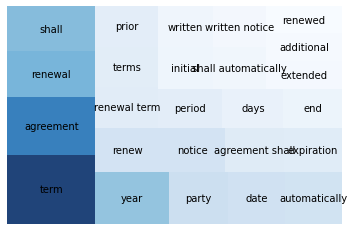

In [18]:
vector_treemap_plotter(auto_renewals_only, "Top 25 Words in Automatic Renewal Clauses")

**What are the top words in Renewal Option Clauses?**

In [19]:
vector_barplotter(renewal_options_only, "Top 25 Words in Renewal Option Clauses", "Word")

/Users/grahamlim/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



### Interpretation

1. **Other Clauses**: Recalling that other clauses comprise every other type of common contract clause apart from renewals, the first bar graph is really a general visualization of  what specific words tend to pop up in most agreements. We can interpret top words we see that our top keywords are "shall", "agreement", "company", "party" and "term". 

    These aren't very helpful and generally just show that contracts will have language designed to compel parties (including companies) to do something in an agreement for a period of time. 
    
    What's a little more illuminating is that we see other top keywords that include "product", "service", and "license", which does remind us that contracts can be for transactions both tangible and intangible property.
    
    'Damage' also appears as one of our top words. That's important because it demonstrates a very important concept in contracts: liability and compensation. When things go south and parties lose something because of e.g. another party's negligence or failure to perform the contract properly, the party at loss is usually entitled to monetary compensation i.e. damages.
    
    
2. **Automatic Renewal Clauses**: We see specific top keywords in the Treemap. Words that are situated in darker blue and wider rectangles indicate more frequently used words. 

    Unsurprisingly, "automatically renew" and "automatically" are common words/bigrams used in these clauses, as is the bigram "write notice". Written notice is an important concept in contract. In the case of automatically renewing contracts, this doesn't force companies who don't want to renew to actually renew; the parties are free to provide written notice usually within a specific period to express their intention to stop further renewals.
    
3. **Renewal Option Clauses**: Unlike automatic renewal clauses, renewal options by definition don't let contracts renew without requirements being satisfied first. This is why "condition" is a top word, as are bigrams that use the word "option" e.g. "renewal option". 

    There are also many words that are to do with leases e.g. "lease", "tenant", "landlord", "lessee". This reflects the fact that some of the most commonly found renewal option clauses are in tenancy leases, at least from scraping `LawInsider.com`. 

## Topic Modelling as "Bag of Words" EDA: Insights
By using Topic Modelling, can we discern any topics/subjects that distinctly cluster within our contract clause data?
* According to Li, Topic Modelling is "statistical modeling for discovering the abstract 'topics' that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic." 

    (Source: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24#:~:text=Topic%20modeling%20is%20a%20type,document%20to%20a%20particular%20topic.)
    
    
* In summary, how LDA works is it assumes that 1 document is mostly about 1 topic, so the words in that document will be about one topic, and there won't be very many other topics in one document. That's known as a Dirichlet distribution.


* An LDA model will then guess what words go in what topics by comparing words with guessed topics. If the words don't fit in the topic distribution, it changes the topic the word is in. It keeps doing this until fewer and fewer words have to have their topic label changed. It therefore has similarity with clustering:

    (Source: https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d#:~:text=Why%20use%20LDA%3F,cluster%20(hard-clustering).)

In [20]:
#we first create an object that comprises the array of all our clause text
clause_text = df["clause_text"]

In [21]:
#we instantiate another vectorizer this time using CountVectorizer for LDA.
vectorizer_lda = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,2))

In [22]:
#we then fit the vectorizer onto our clause text
dtm=vectorizer_lda.fit_transform(clause_text)

In [23]:
#we now instantiate the Latent Dirichlet Allocation machine learning algo from sklearn
#this lets us do topic modelling when we fit it. 

#We pick the number of topics "n_components" to be 15 because we scraped 15 different clause types 
lda=LatentDirichletAllocation(n_components=15)
lda.fit_transform(dtm)

array([[7.93652017e-04, 7.93651444e-04, 7.93651667e-04, ...,
        1.11166701e-01, 1.84875555e-01, 8.44119826e-02],
       [1.51515241e-03, 1.51515188e-03, 1.51515216e-03, ...,
        1.51515205e-03, 3.94951809e-01, 1.51515218e-03],
       [4.50450975e-04, 4.50450660e-04, 4.50451141e-04, ...,
        5.14085577e-02, 7.53262440e-01, 4.50450879e-04],
       ...,
       [2.77778679e-03, 2.77778548e-03, 2.77778677e-03, ...,
        2.77778225e-03, 2.77778260e-03, 2.77778150e-03],
       [4.30108203e-01, 1.44927590e-03, 1.44927631e-03, ...,
        1.44927699e-03, 1.44927704e-03, 1.44927948e-03],
       [7.09220633e-04, 7.09220583e-04, 7.09220944e-04, ...,
        7.09221198e-04, 7.52571302e-01, 7.09221056e-04]])

In [24]:
#we then utilize our pyLDAvis visualization library that lets us open up an interactive chart here in Jupyter.
#to do this we instantiate the pyLDAvis object as well as enable the settings to run with Jupyter like so:
from __future__ import  print_function
pyLDAvis.enable_notebook()
zit=pyLDAvis.sklearn.prepare(lda,dtm,vectorizer_lda)
viz = pyLDAvis.display(zit)

**What are the distinct topics or subjects that can be discerned from our corpora of contract clauses?**

In [25]:
#what distinct topical clusters has LDA found for us?
viz

### Interpretation

Unlike simply ranking top word vectors, LDA has clustered what it sees as specific topics for us to analyze. By mousing over each circle, we see the top 30 words in it - with red bars signifying a particular term's frequency within that topic.


* **Distinct topic clusters:** The LDA model has classified Topics 13 and 6 to be distinct clusters. For example, if we mouse over topic 6, we see that the top words include "warranty" and "defect". It's almost certain that this cluster of words has to do with warranty clauses, which commonly involves suppliers of goods guaranteeing that their products are fit for their purpose e.g. laptops are fit for being used by computer users and actually work. 

That's a pretty good representation of the fact that some clauses are highly specialized in providing specific protections to parties in it.

* **Overlapping topic clusters:** The rest of the topics, however, involve some form of overlap. This is what sets LDA apart from traditional clustering models - k-means clustering, for example, aims to define very distinct, non-overlapping clusters, unlike LDA, which is "softer".

For example, Topic 4 has the most frequently utilized usage of the words "tenant, "renewal" and "renewal option", and it has a small overlap with Topic 9, which has keywords like "loan" and "mortgage". 

What we can possibly infer from this is this is that Topic 4 is mostly about the renewal of tenancy agreements; whilst Topic 9 is about credit agreements. They're distinct topics, but they overlap in that both concern the lending of something (lending or leasing property to renters, or money to borrowers). 

This reflects the fact that sometimes, clauses may be talking about different subjects, but have common elements.

## Dependency Parsing EDA: What "Bag-of-Words" Models don't account for

**If we conclude that the majority of topics/subjects in a contract tend to overlap, it means that a Bag of Words approach may not be ideal,** because even distinctly labelled subjects can have a high degree of similarity that could confuse a machine learning model that is attempting to pick apart renewal option/automatic renewal clauses from each other, or from other clauses.

This is reflective of the reality that people don't classify language by seeing frequently used words in a corpus. We read things from left to right, our brains comprehend the language and we take in the syntax and relationships that each word has with each other.

This also means that `Lemmatization` and `Stopword Removal` actually cause a loss in meaning, and while their usage may be necessary for conventional Word Vectorization models, the process isn't organic.

**Can we visualize the dependency of tokens with each other that we lost in a Bag of Words?**

For the final part of our EDA, we will visualize the relationship between tokens in our sample clause sentences. spaCy actually has a way of understanding and displaying the dependency that words have on each other to form meaning. It does this through `dependency parsing`.

Blackstone summarizes the process as such:

"Dependency parsing is a complex and fine-grained area of study, but it essentially boils down to modelling the relationships between tokens." 

In [49]:
displacy.render(doc, style = "dep", jupyter=True)

1. We see an arc starting from `Carlson` and pointing back to `Nancy` with a label `compound`. This tells us that the dependency parse has identified the tokens `Nancy` and `Carlson` as a compound of proper nouns, which is correct because `Nancy Carlson` is a compound of a first and last name. 

2. We see an arc starting from `Carlson` (which, as we have seen is part of a compound of proper nouns with `Nancy`) and pointing back to `Petitioner`. This is probably helpful in this context, because Nancy Carlson is the petition in the case. 

3. We see an arc starting from `obtained` and sweeping back to `Carlson` (which, as we have seen in part of a compound of proper nouns that can be used to identify Nancy Carlson as the petitioner in the case). The label on the arc, `nsubj`, tells us that `Petitioner Nancy Carlson` is the noun subject of the verb `obtained`. 

4. What is it that Nancy Carlson obtained? The dependency parse provides the answer here. If trace the arc running from `obtained`, we see that it lands on the noun `judgment` with a label of `dobj`. This tells us the `judgment` is the dependent object of the verb `obtained`. The parse is telling us that Nancy Carlson obtained a judgment. 

Now, clearly we can see that for ourselves simply by reading the first few words in the sentence. But, remember that we're potentially performing an analysis on a corpus of documents that is way too big to for us to read manually. The purpose of the dependency parse is to provide us with the means to programmatically and automatically extract these patterns!